### test yolov1

##### test net

In [2]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(f'.'))))
print(f'{sys.path=}')
from importlib import reload
from src.nets.yolov1.resnet_yolo import resnet50
import torch
import numpy as np

from IPython.display import display, HTML
display(HTML('<style>.container{width:100% !important;}</style>'))

sys.path=['/data/ylw/code/pl_yolo/src/test', '/home/jiangxing/anaconda3/envs/train/lib/python39.zip', '/home/jiangxing/anaconda3/envs/train/lib/python3.9', '/home/jiangxing/anaconda3/envs/train/lib/python3.9/lib-dynload', '', '/home/jiangxing/anaconda3/envs/train/lib/python3.9/site-packages', '/home/jiangxing/anaconda3/envs/train/lib/python3.9/site-packages/labelme-5.0.1-py3.9.egg', '/data/ylw/code/pl_yolo']


In [3]:
net = resnet50()
x = torch.randn(size=(2, 3, 416, 416))
y = net(x)
print(f'{x.shape=}  {y.shape=}')

x.shape=torch.Size([2, 3, 416, 416])  y.shape=torch.Size([2, 13, 13, 30])


/home/jiangxing/anaconda3/envs/train/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [4]:
from torchvision import models
mb = models.mobilenet_v2(pretrained=False)

x = torch.randn(size=(2, 3, 416, 416))
y = mb(x)
print(f'{x.shape=}  {y.shape=}')

x.shape=torch.Size([2, 3, 416, 416])  y.shape=torch.Size([2, 1000])


In [5]:
from src.nets.yolov1 import mobilev2
# from src.nets.yolov1.mobilev2 import MobileNetV2
reload(mobilev2)

# mb = mobilev2.MobileNetV2()
mb = mobilev2.get_mobilenet_v2()

x = torch.randn(size=(2, 3, 416, 416))
y = mb(x)
print(f'{x.shape=}  {y.shape=}')

<module 'src.nets.yolov1.mobilev2' from '/data/ylw/code/pl_yolo/src/nets/yolov1/mobilev2.py'>

x.shape=torch.Size([2, 3, 416, 416])  y.shape=torch.Size([2, 13, 13, 30])


/home/jiangxing/anaconda3/envs/train/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


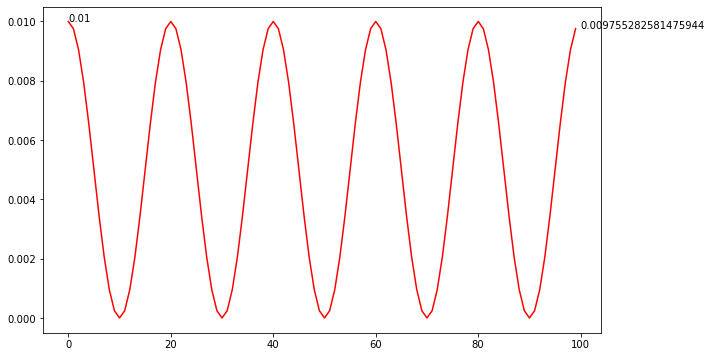

In [22]:
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt


optimizer = torch.optim.Adam(
            mb.parameters(),
            lr=0.01,
            weight_decay=1e-5
        )

lr_scheduler = lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=10, 
    eta_min=0
)

lrs = []
epochs = 100
for epoch in range(epochs): 
    optimizer.step()
    lrs.append(optimizer.state_dict()['param_groups'][0]['lr'])
    lr_scheduler.step()

plt.figure(figsize=(10, 6))   
plt.plot(lrs, color='r')
plt.text(0, lrs[0], str(lrs[0]))
plt.text(epochs, lrs[-1], str(lrs[-1]))
plt.show();

## test yolov3 - 1

#### test dataset

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(f'.'))))
print(f'{sys.path=}')
from importlib import reload
import src.dataset.yolov3.datasets as datasets
reload(datasets)
import torch
import torchvision
import numpy as np

from IPython.display import display, HTML
display(HTML('<style>.container{width:100% !important;}</style>'))

sys.path=['/data/ylw/code/pl_yolo/src/test', '/home/jiangxing/anaconda3/envs/train/lib/python39.zip', '/home/jiangxing/anaconda3/envs/train/lib/python3.9', '/home/jiangxing/anaconda3/envs/train/lib/python3.9/lib-dynload', '', '/home/jiangxing/anaconda3/envs/train/lib/python3.9/site-packages', '/home/jiangxing/anaconda3/envs/train/lib/python3.9/site-packages/labelme-5.0.1-py3.9.egg', '/data/ylw/code/pl_yolo']


<module 'src.dataset.yolov3.datasets' from '/data/ylw/code/pl_yolo/src/dataset/yolov3/datasets.py'>

In [2]:
import torch
import torch.nn.functional as F
import numpy as np

import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

import torchvision.transforms as transforms


def xywh2xyxy_np(x):
    y = np.zeros_like(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


class ImgAug(object):
    def __init__(self, augmentations=[]):
        self.augmentations = augmentations

    def __call__(self, data):
        # Unpack data
        img, boxes = data

        # Convert xywh to xyxy
        boxes = np.array(boxes)
        boxes[:, 1:] = xywh2xyxy_np(boxes[:, 1:])

        # Convert bounding boxes to imgaug
        bounding_boxes = BoundingBoxesOnImage(
            [BoundingBox(*box[1:], label=box[0]) for box in boxes],
            shape=img.shape)

        # Apply augmentations
        img, bounding_boxes = self.augmentations(
            image=img,
            bounding_boxes=bounding_boxes)

        # Clip out of image boxes
        bounding_boxes = bounding_boxes.clip_out_of_image()

        # Convert bounding boxes back to numpy
        boxes = np.zeros((len(bounding_boxes), 5))
        for box_idx, box in enumerate(bounding_boxes):
            # Extract coordinates for unpadded + unscaled image
            x1 = box.x1
            y1 = box.y1
            x2 = box.x2
            y2 = box.y2

            # Returns (x, y, w, h)
            boxes[box_idx, 0] = box.label
            boxes[box_idx, 1] = ((x1 + x2) / 2)
            boxes[box_idx, 2] = ((y1 + y2) / 2)
            boxes[box_idx, 3] = (x2 - x1)
            boxes[box_idx, 4] = (y2 - y1)

        return img, boxes


class RelativeLabels(object):
    def __init__(self, ):
        pass

    def __call__(self, data):
        img, boxes = data
        h, w, _ = img.shape
        boxes[:, [1, 3]] /= w
        boxes[:, [2, 4]] /= h
        return img, boxes


class AbsoluteLabels(object):
    def __init__(self, ):
        pass

    def __call__(self, data):
        img, boxes = data
        h, w, _ = img.shape
        boxes[:, [1, 3]] *= w
        boxes[:, [2, 4]] *= h
        return img, boxes


class PadSquare(ImgAug):
    def __init__(self, ):
        self.augmentations = iaa.Sequential([
            iaa.PadToAspectRatio(
                1.0,
                position="center-center").to_deterministic()
        ])


class ToTensor(object):
    def __init__(self, ):
        pass

    def __call__(self, data):
        img, boxes = data
        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(img)

        bb_targets = torch.zeros((len(boxes), 6))
        bb_targets[:, 1:] = transforms.ToTensor()(boxes)

        return img, bb_targets


class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, data):
        img, boxes = data
        img = F.interpolate(img.unsqueeze(0), size=self.size, mode="nearest").squeeze(0)
        return img, boxes

class DefaultAug(ImgAug):
    def __init__(self, ):
        self.augmentations = iaa.Sequential([
            iaa.Sharpen((0.0, 0.1)),
            iaa.Affine(rotate=(-0, 0), translate_percent=(-0.1, 0.1), scale=(0.8, 1.5)),
            iaa.AddToBrightness((-60, 40)),
            iaa.AddToHue((-10, 10)),
            iaa.Fliplr(0.5),
        ])


DEFAULT_TRANSFORMS = transforms.Compose([
    AbsoluteLabels(),
    PadSquare(),
    RelativeLabels(),
    ToTensor(),
])


In [4]:
import torchvision.transforms as transforms


data_dir = f'/data/ylw/datasets/voc/VOC2007/JPEGImages'
list_file = [
    f'/data/ylw/code/pl_yolo/data/yolov1/voc2007.txt',
    f'/data/ylw/code/pl_yolo/data/yolov1/voc2012.txt'
]
BATCH_SIZE = 2

dataset = datasets.ListDataset(
    data_dir, 
    list_file, 
    img_size=416, 
    multiscale=True, 
    transform=torchvision.transforms.Compose([
        # AbsoluteLabels(),
        # DefaultAug(),
        # PadSquare(),
        # RelativeLabels(),
        ToTensor(),
    ])
)
loader = torch.utils.data.DataLoader(
    dataset, 
    shuffle = False, 
    batch_size = BATCH_SIZE, 
    num_workers = 4, 
    pin_memory=True,
    drop_last=True, 
    collate_fn=dataset.collate_fn
)


for idx, batch in enumerate(loader):
    print(f'{batch}')
    break

['/data/ylw/code/pl_yolo/data/yolov1/voc2007.txt', '/data/ylw/code/pl_yolo/data/yolov1/voc2012.txt']
[------------]  img.shape=(375, 500, 3)  boxes.shape=torch.Size([1, 4])[------------]  img.shape=(322, 500, 3)  boxes.shape=torch.Size([2, 4])
[------------]  img.shape=(375, 500, 3)  boxes.shape=torch.Size([3, 4])[------------]  img.shape=(387, 500, 3)  boxes.shape=torch.Size([1, 4])


Could not apply transform.
Could not apply transform.Could not apply transform.

Could not apply transform.
[------------]  img.shape=(499, 333, 3)  boxes.shape=torch.Size([1, 4])
[------------]  img.shape=(500, 375, 3)  boxes.shape=torch.Size([1, 4])[------------]  img.shape=(375, 500, 3)  boxes.shape=torch.Size([3, 4])

Could not apply transform.
[------------]  img.shape=(404, 500, 3)  boxes.shape=torch.Size([1, 4])Could not apply transform.

Could not apply transform.[------------]  img.shape=(375, 500, 3)  boxes.shape=torch.Size([2, 4])

Could not apply transform.Could not apply transform.


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/jiangxing/anaconda3/envs/train/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/jiangxing/anaconda3/envs/train/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/data/ylw/code/pl_yolo/src/dataset/yolov3/datasets.py", line 154, in collate_fn
    paths, imgs, bb_targets = list(zip(*batch))
ValueError: not enough values to unpack (expected 3, got 0)



[------------]  img.shape=(333, 500, 3)  boxes.shape=torch.Size([2, 4])
[------------]  img.shape=(350, 500, 3)  boxes.shape=torch.Size([3, 4])
[------------]  img.shape=(500, 375, 3)  boxes.shape=torch.Size([2, 4])Could not apply transform.